# HPDM097: Introduction to combinatorial optimisation for geospatial problems

## **Case study**: An applied facility location problem: sexual clinics in Hampshire, UK

The data you will use in the exercises in this computer lab is taken from a real facility location study conducted in Hampshire.  The data science team worked with commissioners, a public health team, and a community NHS trust in Hampshire that were reviewing the provision of sexual health clinics across the region.  The data science 'customers' had a number of concerns about the current provision of sexual health care.  One of these was the sustainability of the adult service across 28 locations.  There was a growing concern that care varied and the data scientists were asked to identify promising configurations that preserved fair access for patients.

**By the end of this lab you will have learnt how to:**

* represent a facility location problem in a general format suitable for algorithmic solution
* solve the p-median facility location problem using a brute force approach
* solve a larger p-median problem by applying an evolutionary optimisation approach
* obtain a good solution to large instances of the p-median problem by applying a Genetic Algorithm.

> Please use the conda environment `hds_logistics` when running this workbook.  You will also need to run this workbook in the same directory as `metapy`.  This is a small python package that contains the evolutionary and genetic algorithm code.

The first part of the notebook will walk you through the basics of representing a solution, generating random solutions, and evaluating a solution.  You will then be asked to complete a number of exercises using these fundamentals to locate facilities in partial and full instances of the case study.

# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# you will use itertools for enumerating all solutions in small instances.
from itertools import combinations

# `metapy` package imports

The package contains the classes and functions for the evolutionary algorithms you will use in this notebook.

In [2]:
from metapy.evolutionary.evolutionary import (EvolutionaryAlgorithm, 
                                              MuLambdaEvolutionStrategy, 
                                              MuPlusLambdaEvolutionStrategy,
                                              GeneticAlgorithmStrategy,
                                              ElitistGeneticAlgorithmStrategy,
                                              WeightedAverageObjective,
                                              FacilityLocationPopulationGenerator,
                                              BasicFacilityLocationMutator,
                                              TournamentSelector,
                                              FacilityLocationSinglePointCrossOver)

# Import case study data

The car travel times in minutes from annoymised postcode sectors to annoymised clinic locations.

In [3]:
travel_matrix = pd.read_csv('data/clinic_car_travel_time.csv', 
                            index_col='sector')
travel_matrix.head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,...,clinic_19,clinic_20,clinic_21,clinic_22,clinic_23,clinic_24,clinic_25,clinic_26,clinic_27,clinic_28
sector,,,,,,,,,,,,,,,,,,,,,
PS158,33.17,40.15,38.17,37.93,29.35,51.48,53.28,48.00,53.82,44.65,...,12.10,12.27,15.83,53.27,53.98,29.75,34.22,32.68,19.62,39.25
PS159,31.42,36.55,36.42,34.53,27.60,47.88,49.68,44.40,50.22,41.05,...,11.75,11.92,10.62,49.68,50.38,26.15,30.62,32.35,19.28,35.65
PS160,31.82,38.80,36.82,36.58,28.00,50.13,51.95,46.65,52.47,43.30,...,10.75,10.92,14.35,51.93,52.65,28.40,32.87,31.35,18.27,37.90
PS161,31.68,38.65,36.67,36.43,27.87,49.98,51.80,46.50,52.32,43.17,...,10.32,10.77,16.38,51.78,52.50,28.27,32.73,31.20,17.82,37.75
PS162,29.55,36.53,34.55,34.32,25.73,47.87,49.67,44.38,50.20,41.03,...,6.77,7.28,17.18,49.65,50.37,26.13,30.60,29.07,14.27,35.63


In [4]:
# no of cases by postcode sector...

cases = pd.read_csv('data/sh_demand.csv', index_col='sector')
cases.head()

,n_patients
sector,
PS1,3375
PS2,3338
PS3,2922
PS4,3191
PS5,3134


# Representing a solution

To solve the facility location problem using an an algorithm you need to decide how to represent a solution.  

You will represent a solution using a vector of length $p$ where $p <= P$.  Each element represents the index of a clinic.  For example, if we have $P = 28$ candidate locations for clinics and wish to find the best solution where $p = 4$

```python
solution = np.array([10, 0, 6, 12])
```
means that clinics which indicies 10, 0, 6, and 12 are included in the solution.

To select a set of clinics from a `pandas.DataFrame` you can use the code below.  The indicies are used select the column headers and the column headers are then used to select the column data from the dataframe.

In [5]:
# the solution represents the indicies of clinics in the travel matrix
solution = np.array([10, 0, 6, 12])

# this code looks up the column names using the indicies in the solution
# if you are unsure what it does then print out `mask`
mask = travel_matrix.columns[solution]

# finally we select a restricted set of columns from the DataFrame
travel_matrix[mask]

,clinic_11,clinic_1,clinic_7,clinic_13
sector,,,,
PS158,49.40,33.17,53.28,52.78
PS159,45.80,31.42,49.68,49.18
PS160,48.05,31.82,51.95,51.43
PS161,47.92,31.68,51.80,51.30
PS162,45.78,29.55,49.67,49.17
...,...,...,...,...
PS273,47.18,34.13,49.08,50.57
PS157,42.65,29.60,44.55,46.03
PS274,44.23,31.17,46.13,47.62


# Constructing a random solution

It is unusual to specify an initial solution in facility location.  It is more usual to **generate** one or more random solutions as a starting place.

The function `random_solution` accepts:
* `n_candidates`: The number of candidate locations where you could place clinics (facilities)
* `p` the number of clinics to place.
* `random_seed` (optional).  Use if you wanted to recreate your results.

In [6]:
def random_solution(n_candidates, p, random_seed=None):
    '''
    construct a random solution for the facility location
    problem.  Returns vector of length p
    '''
    # create a random number generator
    rng = np.random.default_rng(seed=random_seed)

    # sample without replacement
    solution = []
    while len(solution) < p:
        candidate = rng.integers(0, n_candidates)
        if candidate not in solution:
            solution.append(candidate)
            
    return np.array(solution)

In [7]:
init_solution = random_solution(28, 4, random_seed=42)
init_solution

array([ 2, 21, 18, 12])

It is not strictly necessary, but if you wish to have a more efficient implementation of the above you can make use of numpy's built-in `choice` method that allows you to sample **without** replacement.

In [8]:
def random_solution2(n_candidates, p, random_seed=None):
    '''
    construct a random solution for the facility location
    problem.  Returns vector of length p
    '''
    # create a random number generator
    rng = np.random.default_rng(seed=random_seed)
    
    # create array of candidate indexes
    candidates = np.arange(n_candidates, dtype=np.byte)
    
    # sample without replacement and return array
    return rng.choice(candidates, size=p, replace=False)

In [9]:
init_solution = random_solution2(28, 4)
init_solution

array([11, 26, 24, 27], dtype=int8)

# Evaluating a solution

There are multiple ways to formulate the objectives of a facility location problem.  With the sexual health case study you will formulate the it as a p-median problem.  Where the objective is to find the combination of facilities that minimises the weighted average car travel time to a clinic.

`metapy` contains a `WeightAverageObjective` class that accepts both the geospatial demand and travel matrix as parameters.

```python
from metapy.evolutionary.evolutionary import WeightedAverageObjective

# create an instance and pass in demand and travel times
obj = WeightedAverageObjective(cases, travel_matrix)
```

The object has a method `evaluate(solution)` that accepts a numpy vector that is your representation of the a solution.

```python
obj.evaluate(solution)
```

The code below brings these together.  Execute the cell to see the output.

In [10]:
obj = WeightedAverageObjective(cases, travel_matrix)
obj.evaluate(solution)

np.float64(14.510030062602892)

# Solution of a small facility location problem by enumerating all possible combinations

For small problems it is possible to enumerate all combinations to locate the "optimal" solution.  

The function `all_combinations` below will provide a list of solutions representing an exhaustive solution space for a given problem.  For example, if the problem consisted of 10 candidate locations and you wish to evaluate solutions of size 4 then the solution space is fully represented by 210 unique solutions.

This method is straightforward for health service customers to understand and for small problems it is unusual to use a complex optimisation procedure.  As the facility location problem is NP hard, this strategy is not recommended for large scale problems.  The evaluation of the fitness of the solutions will become prohibitive as the size of the problem begins to exceed 10.

In [11]:
def all_combinations(n_facilities, p):
    '''
    Returns all p sized combinations of an array containing
    indicies 0 to n_facilties - 1 
    '''
    facility = np.arange(n_facilities, dtype=np.uint8)
    return [np.array(a) for a in combinations(facility, p)]

In [12]:
# size 4 combinations of 10 candidate locations = 210
comb = all_combinations(n_facilities=10, p=4)
len(comb)

210

In [13]:
# take a look at index 0
comb[0]

array([0, 1, 2, 3], dtype=uint8)

In [14]:
# index 209
comb[-1]

array([6, 7, 8, 9], dtype=uint8)

# Exercise 1: Bruteforce solution

As an example we will work with the **first six clinics** and look to find the optimal 4 sites according to the weighted average.

**Task:**
* Generate all combinations to place 4 facilities in a problem with 6 candidate locations.
* For each of the solutions calculate the weighted average travel time.
* Select the solution with the lowest weight mean car travel time.
* Illustrate all of the solutions on a bar chart.  

**Questions:**
* Does the problem have a unique "optimal" solution or are there other solutions that a health service customer might consider?
* Are there any limitations with the data that make it important to report more than a single solution?
* What happens to the travel times and solution if $p$ is reduced to 3?

In [15]:
# your code goes here ...

In [16]:
# example solution

# size 4 combinations of 6 candidate locations = 15 combinations
comb = all_combinations(n_facilities=6, p=4)
len(comb)

15

In [17]:
comb

[array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 2, 4], dtype=uint8),
 array([0, 1, 2, 5], dtype=uint8),
 array([0, 1, 3, 4], dtype=uint8),
 array([0, 1, 3, 5], dtype=uint8),
 array([0, 1, 4, 5], dtype=uint8),
 array([0, 2, 3, 4], dtype=uint8),
 array([0, 2, 3, 5], dtype=uint8),
 array([0, 2, 4, 5], dtype=uint8),
 array([0, 3, 4, 5], dtype=uint8),
 array([1, 2, 3, 4], dtype=uint8),
 array([1, 2, 3, 5], dtype=uint8),
 array([1, 2, 4, 5], dtype=uint8),
 array([1, 3, 4, 5], dtype=uint8),
 array([2, 3, 4, 5], dtype=uint8)]

optimal cost: 12.919422203379565
optimal solution: [1 3 4 5]


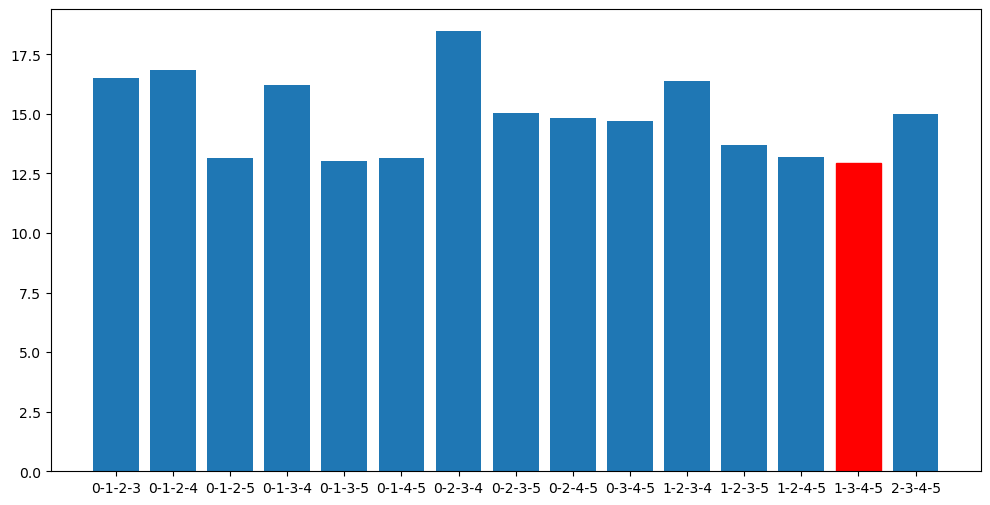

In [18]:
# example solution...

# create objective function...
obj = WeightedAverageObjective(cases, travel_matrix)

results = []
for solution in comb:
    results.append(obj.evaluate(solution))
results = np.array(results)

# get the index of the minimum
optimal_index = np.argmin(results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# convert solutions to strings

xlabels = []
for solution in comb:
    label = '-'.join(str(a) for a in solution)
    xlabels.append(label)

barlist = ax.bar(xlabels, results)
barlist[optimal_index].set_color('r')

print(f'optimal cost: {results[optimal_index]}')
print(f'optimal solution: {comb[optimal_index]}')

20 combinations
optimal cost: 13.512949934203643
optimal solution: [0 1 5]


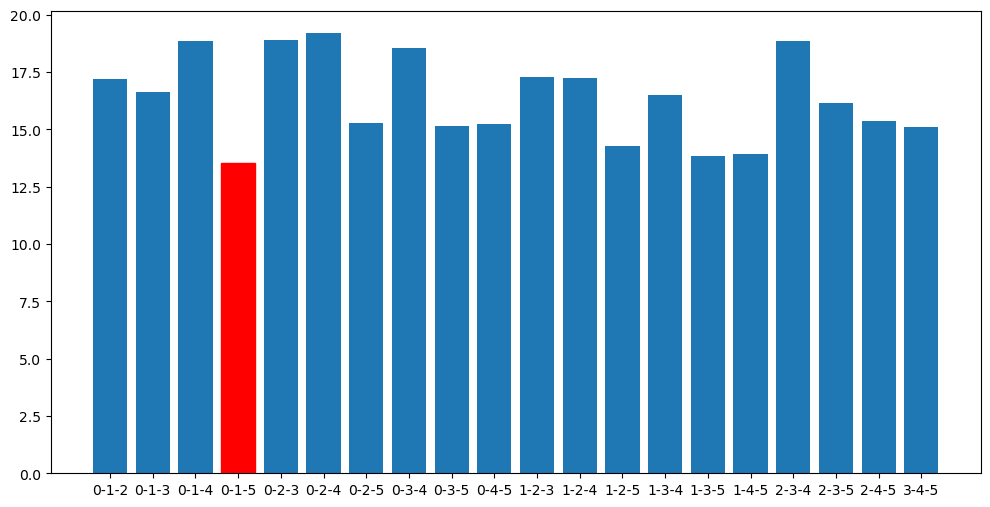

In [19]:
# reduce p to 3
comb = all_combinations(n_facilities=6, p=3)
print(f'{len(comb)} combinations')
# create objective function...
obj = WeightedAverageObjective(cases, travel_matrix)

results = []
for solution in comb:
    results.append(obj.evaluate(solution))
results = np.array(results)

# get the index of the minimum
optimal_index = np.argmin(results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# convert solutions to strings

xlabels = []
for solution in comb:
    label = '-'.join(str(a) for a in solution)
    xlabels.append(label)

barlist = ax.bar(xlabels, results)
barlist[optimal_index].set_color('r')

print(f'optimal cost: {results[optimal_index]}')
print(f'optimal solution: {comb[optimal_index]}')

# Exercise 2: Using random restarts with medium to large sized problems

When you encounter a medium to large instance of a facility location problem (or any optimisation problem) it is often tempting to move quickly onto a sophisticated solution method such as a evolutionary algorithm.  But how do you know that it is better than a simple heuristic?  

**Here you will use the random restarts algorithm (sometimes called random search) as a simple benchmark.**

Random restarts is simple heuristic.  You allocate a computational budget - either in terms of iterations or execution time - and randomly generate solutions and evaluate them. For example, you might specify an execution time limit of 10 seconds and in that time evaluate as many random solutions as possible.  

> A neat trick with this type of algorithm is to remember that it is 'Embarrassingly parallelisible'.  That is, if your machine has multiple virtual cores then you can run multiple random searches simultaneously and return the best solution.  

**Task:**
* Using the `random_solution` function defined earlier create another function `random_restarts` (or class `RandomRestarts` if you prefer) that runs for fixed number of iterations.  For example if you specify iterations as 10 then the algorithm generates 10 random solutions and evaluates them.  
* The function should return a tuple of the best cost and best solution found when minimising the weighted average car travel time.
* Problem: 20 candidate locations and a budget of 8 clinics to place.
* Try running the algorithm a few times or varying your budget. What do you notice?  What might you do to get a better understanding of the algorithms performance?

In [20]:
# your code goes here ...

In [21]:
# example solution

def random_restarts(max_iter, obj, n_facilities=28, p=14, random_seed=None):
    
    np.random.seed(random_seed)
    
    # implementation of random restarts alg
    # code modified for 2025. np.Inf deprecated for np.inf
    best_cost = np.inf
    best_solution = None
    for i in range(max_iter):
        solution = random_solution(n_facilities, p)
        cost = obj.evaluate(solution)
        
        if cost < best_cost:
            best_cost = cost
            best_solution = solution
            
    return best_cost, solution
        

In [22]:
max_iter = 1000

# create objective function...
obj = WeightedAverageObjective(cases, travel_matrix)

random_restarts(max_iter, obj)

(np.float64(6.0594942214832),
 array([17, 16,  9,  7, 19,  4,  3, 15, 25,  0, 14,  6,  2, 27]))

# Exercise 3: Solution using a evolutionary algorithm

## Exercise 3.1 Generating an initial population.

The first task when using a population based method is to create an initial random population of solutions!  For our purposes, this is a multi-dimensional array.  We can use an object of type `FacilityLocationPopulationGenerator` to do the work for us here.

```python
from metapy.evolutionary.evolutionary import FacilityLocationPopulationGenerator
```

`FacilityLocationPopulationGenerator` accepts three arguments when it is created:

* n_candidates: int.  This is $P$ the number of candidate locations
* n_facilities: int. This is $p$ the number of facilities to place.
* random_seed: int, optional (default=None).  Set if you want a reproducible result.  For example = 42.

`FacilityLocationPopulationGenerator` has a single method `generate` that accepts a parameter specifying the population size.  It returns a multi-dimensional numpy array.

Let's assume you want have a problem with $P$ = 28, $p$ = 8 and we want to create a population of size 10.

```python
#example solution
N_CANDIDATES = 28
N_FACILITIES = 8
SEED = 42
POPULATION_SIZE = 10

gen = FacilityLocationPopulationGenerator(n_candidates=N_CANDIDATES,
                                          n_facilities=N_FACILITIES,
                                          random_seed=SEED)


gen.generate(population_size=POPULATION_SIZE)
```

**Task:**

* Run the example code given above to create an initial population.  

In [23]:
# example solution
N_CANDIDATES = 28
N_FACILITIES = 8
SEED = 42
POPULATION_SIZE = 10

gen = FacilityLocationPopulationGenerator(n_candidates=N_CANDIDATES,
                                          n_facilities=N_FACILITIES,
                                          random_seed=SEED)


gen.generate(population_size=10)

array([[ 2, 19, 22, 15, 24, 10,  1, 17],
       [24, 16, 11, 10,  2, 20, 13,  5],
       [23,  1,  4, 27, 13,  9, 22,  2],
       [ 5,  9, 19, 25, 22, 20, 10, 16],
       [ 8, 24, 25, 16, 27, 10, 23, 19],
       [24, 13,  5,  7,  9,  4, 16, 11],
       [19, 17, 27, 23,  6, 22,  9,  7],
       [17, 15,  7, 24, 16, 21, 27, 11],
       [25,  2, 14,  9, 15, 11, 27, 21],
       [13,  7,  0, 10,  6, 25,  5,  8]], dtype=int8)

# Exercise 3.2: Mutating a solution

Basic evolutionary strategies work by mutating the most promising solutions in the population.  There are many ways to implement mutation.  Here you will use `BasicFacilityLocationMutator`.  Each element in a solution has a constant probability of mutation (by default 1 / no. of facilities in a solution, but you may wish to set this higher.).  If a facility is chosen then it is replaced by a random facility current not in the solution.

You can create a `BasicFacilityLocationMutator` as follows:

```python
mutator = FacilityLocationMutator(n_candidates=28, solution_size=4)
solution = np.array([1, 2, 3, 4])

mutant = mutator.mutate(solution)
print(mutant)
```

To use a higher mutation rate:

```python
mutator = FacilityLocationMutator(n_candidates=28, solution_size=4
                                  mutation_rate=0.6)
solution = np.array([1, 2, 3, 4])

mutant = mutator.mutate(solution)
print(mutant)
```

**Task**:
* Create a `FacilityLocationMutator` with 50 candidate solutions and a solution size of 10
* mutate the solution a total of 10 times and printout the generations.


In [24]:
# your code goes here ...

In [25]:
# example solution

# single mutation example
mutator = BasicFacilityLocationMutator(n_candidates=28, solution_size=4, mutation_rate=0.5)
solution = np.array([10, 11, 12, 13])

print(mutator.mutate(solution))

[10 11 12  5]


In [26]:
# mutating through 5 generations
mutator = BasicFacilityLocationMutator(n_candidates=50, solution_size=5, 
                                       mutation_rate=0.2)
solution = np.arange(5)

for i in range(10):
    solution = mutator.mutate(solution)
    print(f'solution {solution}')


solution [0 1 2 3 4]
solution [0 1 2 3 4]
solution [ 0  2  3  4 36]
solution [ 2  3 36 44 30]
solution [ 2 36 44 49 11]
solution [ 2 44 49 11 30]
solution [44 49 11 30 38]
solution [44 49 11 38 16]
solution [44 49 11 38 16]
solution [44 49 11 38 16]


# Exercise 3.3: The $(\mu, \lambda)$ and $(\mu+\lambda)$ evolutionary strategies

A random initial population and a mutation operator provide the ingredients for the two basic evolutionary strategies $(\mu, \lambda)$ and $(\mu+\lambda)$.

You will use the `metapy` package.  In particular:


**Task:**
* Run two evolutionary algorithms with $(\mu, \lambda)$ and $(\mu+\lambda)$  strategies respectively.  The code is  provided below.
* Investigate the parameters requried when creating `MuPlusLambdaEvolutionStrategy` and `MuLambdaEvolutionStrategy`
* Use a problem size of 28 candidate locations and 14 facilities
* Initially try $mu = 10$ and $\lambda = 200$. 
* Using a random initial population evolve for 50 generations.

**Hints**:
* Evolutionary strategies are computationally expensive.  Expect a 50 generation algorithm to take 20-45 seconds on your machine.

**Questions:**
* How do your new solutions and algorithms compare to `random_restarts?`
* How do the algorithms appear to compare to each other?
* What must your remember about evolutionary algorithms when evaluating their performance?

In [27]:
%%time

# example solution

# Evolutionary Algorithm - (mu+lambda) strategy
n_candidates = 28
n_facilities = 14

mu = 10
_lambda = 200

# objective
objective = WeightedAverageObjective(cases, travel_matrix)

# initial solution generator
init = FacilityLocationPopulationGenerator(n_candidates, n_facilities)

# mutation operator
mutator = BasicFacilityLocationMutator(n_candidates=n_candidates, 
                                       solution_size=n_facilities, 
                                       mutation_rate=0.2, verbose=False)

# evolutionary stategy
strategy = MuPlusLambdaEvolutionStrategy(mu, _lambda, mutator)

# solver object
solver = EvolutionaryAlgorithm(init, objective, _lambda, strategy, 
                               maximisation=False, generations=50)

print("\nRunning (mu + lambda) evolutionary alg...")
solver.solve()

print("\n** (MU+LAMBDA) OUTPUT ***")
print("best cost:\t{0}".format(solver.best_fitness))
print("best solutions:")
print(solver.best_solution)


Running (mu + lambda) evolutionary alg...

** (MU+LAMBDA) OUTPUT ***
best cost:	5.8758212431381835
best solutions:
[15  8 11  0 17 22  4 10  3  1 26  6  7 24]
CPU times: user 22.5 s, sys: 105 ms, total: 22.6 s
Wall time: 22.6 s


In [29]:
%%time

# Evolutionary Algorithm - (mu,lambda) strategy
n_candidates = 28
n_facilities = 14

mu = 10
_lambda = 200

# objective
objective = WeightedAverageObjective(cases, travel_matrix)

# initial solution generator
init = FacilityLocationPopulationGenerator(n_candidates, n_facilities)

# mutation operator
mutator = BasicFacilityLocationMutator(n_candidates=n_candidates, 
                                       solution_size=n_facilities, 
                                       mutation_rate=0.2, verbose=False)

# evolutionary stategy
strategy = MuLambdaEvolutionStrategy(mu, _lambda, mutator)

# solver object
solver = EvolutionaryAlgorithm(init, objective, _lambda, strategy, 
                               maximisation=False, generations=50)

print("\nRunning (mu, lambda) evolutionary alg...")
solver.solve()

print("\n** (MU,LAMBDA) OUTPUT ***")
print("best cost:\t{0}".format(solver.best_fitness))
print("best solutions:")
print(solver.best_solution)


Running (mu, lambda) evolutionary alg...

** (MU,LAMBDA) OUTPUT ***
best cost:	5.884854394590933
best solutions:
[ 0  1  3  4  6  7  8 10 11 15 17 19 22 24]
CPU times: user 22.9 s, sys: 137 μs, total: 22.9 s
Wall time: 22.9 s


# Exercise 4: Locating facilities using a full Genetic Algorithm (GA)

Now that you have warmed up using  $(\mu, \lambda)$ and $(\mu+\lambda)$  it is time to move onto a full GA.  This means you need to take account of two further steps.

* A selection operator for breeding - in this instance you will use the provided `TournamentSelector`
* A crossover operator for breeding - you will use `FacilityLocationSinglePointCrossover`

See lecture slides for details of how these work.

`metapy` provides standard and elitist GA strategies.  The code provided in this task demonstrates how these are instantiated and used to solve the sexual health clinic facility location problem.

**Task:**

The two code blocks below have been provided to demonstrate how to use run the `metapy` implementations of a GA.  Note that these are similar to the two basic evolutionary strategies you used in the previous exercise.  

* Run `GeneticAlgorithmStrategy` and `ElitistGeneticAlgorithmStrategy` using the parameters provided


**Questions**:

* Are you satisfied with the results?  If not you could try changing/tuning the parameters:
    * lambda and mu
    * the number of generations (note this will start to get slow with large numbers)
    * the mutation rate
    * (You could also work with a smaller problem size to speed things up).
    
* Which of the algorithms used fin this case study do you prefer the most and why?

* Ultimately, in practice, if you are not satisfied with the performance of the GA you might need to code new cross-over and mutation operators! 

    

In [30]:
%%time

# Evolutionary Algorithm - Genetic Algorithm strategy

n_candidates = 28
n_facilities = 14

_lambda = 200
# objective
objective = WeightedAverageObjective(cases, travel_matrix)

# initial solution generator
init = FacilityLocationPopulationGenerator(n_candidates, n_facilities)

# mutation operator
mutator = BasicFacilityLocationMutator(n_candidates=n_candidates, 
                                       solution_size=n_facilities, 
                                       mutation_rate=0.2, verbose=False)

# cross over operator
x_over = FacilityLocationSinglePointCrossOver()

#GA strategy
strategy = GeneticAlgorithmStrategy(_lambda, 
                                    selector=TournamentSelector(),
                                    xoperator=x_over,
                                    mutator=mutator)


solver = EvolutionaryAlgorithm(init, objective,_lambda, strategy, 
                               maximisation=False, generations=50)
print("\nRunning Genetic Algorithm")
solver.solve()

print("\n** GA OUTPUT ***")
print("best cost:\t{0}".format(solver.best_fitness))
print("best solutions:")
print(solver.best_solution)


Running Genetic Algorithm

** GA OUTPUT ***
best cost:	6.293889142775339
best solutions:
[ 0  1  3  4  5  7  8 10 11 17 18 22 23 27]
CPU times: user 22.6 s, sys: 8.05 ms, total: 22.6 s
Wall time: 22.6 s


In [31]:
%%time 

# Evolutionary Algorithm - Elitist Genetic Algorithm strategy

n_candidates = 28
n_facilities = 14

# GA parameters
mu = 10
_lambda = 200

# objective
objective = WeightedAverageObjective(cases, travel_matrix)

# initial solution generator
init = FacilityLocationPopulationGenerator(n_candidates, n_facilities)

# mutation operator
mutator = BasicFacilityLocationMutator(n_candidates=n_candidates, 
                                       solution_size=n_facilities, 
                                       mutation_rate=0.2, verbose=False)

# cross over operator
x_over = FacilityLocationSinglePointCrossOver()

# GA strategy
strategy = ElitistGeneticAlgorithmStrategy(mu,
                                           _lambda, 
                                           selector=TournamentSelector(),
                                           xoperator=x_over,
                                           mutator=mutator)


solver = EvolutionaryAlgorithm(init, objective,_lambda, strategy, 
                               maximisation=False, generations=50)
print("\nRunning Elitist Genetic Algorithm")
solver.solve()

print("\n** ELITIST GA OUTPUT ***")
print("best cost:\t{0}".format(solver.best_fitness))
print("best solutions:")
print(solver.best_solution)


Running Elitist Genetic Algorithm

** ELITIST GA OUTPUT ***
best cost:	6.27909751625638
best solutions:
[ 0  3  4  5  8  9 11 12 13 16 17 20 22 27]
CPU times: user 23.5 s, sys: 41 μs, total: 23.5 s
Wall time: 23.5 s


# End